In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from stable_baselines3.common.vec_env import DummyVecEnv
# from sb3_contrib import RecurrentPPO
# from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import random
# from stable_baselines3.common.vec_env import SubprocVecEnv
# import matplotlib.pyplot as plt
# from typing import Tuple, Optional
import math
import mplfinance as mpf
from readAndSortCsv import read_and_sort_csv
from createSequences import create_sequences
from labelSequences import precompute_label_info, get_labels_from_precomputed
from plotData import plot_input_output_combined, plot_input_output_combined_with_label
from trades import compute_profit, compute_sharpe_ratio, compute_trading_statistics
from prepareScaledData import scale_X_0_1, encode_labels, compute_sample_profit, get_profitable_indices, get_flat_indices
from ta import trend, momentum, volatility, volume



In [2]:
# import pandas as pd
# import os
# import glob

# # Define the directory containing the CSV files
# csv_directory = r'E:\AICore\CnnTrading\CnnTrans\Data'  # Change this to your directory path

# # Define the required columns
# required_columns = ['date', 'open', 'high', 'low', 'close', 'volume']

# # Use glob to get all CSV file paths
# csv_files = glob.glob(os.path.join(csv_directory, '*.csv'))

# # Initialize an empty list to hold individual DataFrames
# dataframes = []

# # Iterate over each CSV file
# for file in csv_files:
#     try:
#         # Read the CSV file
#         df = pd.read_csv(file)
#         # print(df.describe())
#         # Check if all required columns are present
#         if all(column in df.columns for column in required_columns):
#             # Select only the required columns
#             df = df[required_columns]
            
#             # Append the DataFrame to the list
#             dataframes.append(df)
#         else:
#             missing = list(set(required_columns) - set(df.columns))
#             print(f"Skipping {file}. Missing columns: {missing}")
#     except Exception as e:
#         print(f"Error reading {file}: {e}")

# # Concatenate all DataFrames
# if dataframes:
#     merged_df = pd.concat(dataframes, ignore_index=True)
    
#     # Convert 'date' column to datetime for proper merging
#     merged_df['date'] = pd.to_datetime(merged_df['date'])
    
#     # Drop duplicate dates if necessary (keeping the first occurrence)
#     merged_df = merged_df.drop_duplicates(subset=['date'], keep='first')
    
#     # Sort by date
#     merged_df = merged_df.sort_values(by='date', ascending=False).reset_index(drop=True)
    
#     # Save the merged DataFrame to a new CSV file
#     merged_df.to_csv('merged_output.csv', index=False)
    
#     print("CSV files have been successfully merged into 'merged_output.csv'.")
# else:
#     print("No valid CSV files found to merge.")


In [3]:
MODEL_PATH = 'simple1dcnn_state_dict.pth'
required_columns = ['date', 'open', 'high', 'low', 'close', 'volume']
file_path = r"E:\AICore\CnnTrading\CnnTrans\merged_output.csv"
input_window = 150
output_window = 15
np.set_printoptions(formatter={'float_kind': lambda x: f'{x:.2f}'})
random.seed(42)
np.random.seed(42)

# Read data and compute X, y, labels

In [ ]:
# 1) Read & sort in descending order
df = read_and_sort_csv(file_path, required_columns)

# Assuming 'df' is your DataFrame with 'open', 'high', 'low', 'close', 'volume'

# Moving Averages
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

# RSI
df['RSI_14'] = momentum.RSIIndicator(close=df['close'], window=14).rsi()

# MACD
macd = trend.MACD(close=df['close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# Bollinger Bands
bollinger = volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# ATR
df['ATR_14'] = volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()

# OBV
df['OBV'] = volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['volume']).on_balance_volume()

# Stochastic Oscillator
stochastic = momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
df['Stochastic_%K'] = stochastic.stoch()
df['Stochastic_%D'] = stochastic.stoch_signal()

# Ichimoku Cloud
ichimoku = trend.IchimokuIndicator(high=df['high'], low=df['low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()
df['Ichimoku_Base_Line'] = ichimoku.ichimoku_base_line()
df['Ichimoku_Conversion_Line'] = ichimoku.ichimoku_conversion_line()

# Handle missing values
df.dropna(inplace=True)  # or df.fillna(method='ffill', inplace=True)

# Display the updated DataFrame


In [12]:
df


,open,high,low,close,volume,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,...,Bollinger_Low,Bollinger_Middle,ATR_14,OBV,Stochastic_%K,Stochastic_%D,Ichimoku_A,Ichimoku_B,Ichimoku_Base_Line,Ichimoku_Conversion_Line
date,,,,,,,,,,,,,,,,,,,,,
2024-12-26 23:26:00,95784.21,95784.21,95674.12,95674.13,15.19492,95716.2175,95699.302191,45.450731,-37.909115,-38.206051,...,95547.006115,95716.2175,77.335429,8.003280,56.170968,56.787097,95656.8975,95678.355,95671.690,95642.105
2024-12-26 23:25:00,95812.61,95812.61,95784.20,95784.21,5.75369,95714.8850,95707.388649,56.131483,-26.418196,-35.848480,...,95548.276038,95714.8850,81.702899,13.756970,90.915198,69.241625,95663.9975,95678.355,95671.690,95656.305
2024-12-26 23:24:00,95774.26,95813.25,95774.25,95812.60,6.25812,95713.3465,95717.408778,58.394092,-14.849549,-31.648694,...,95550.997976,95713.3465,78.652692,20.015090,99.792498,82.292888,95664.1575,95678.355,95671.690,95656.625
2024-12-26 23:23:00,95781.30,95783.13,95751.56,95774.26,5.32832,95711.2760,95722.823180,54.319503,-8.675029,-27.053961,...,95553.200174,95711.2760,77.394642,14.686770,87.553073,92.753589,95664.1575,95678.355,95671.690,95656.625
2024-12-26 23:22:00,95779.99,95823.48,95768.03,95781.30,18.26921,95709.9570,95728.392401,54.941230,-3.176986,-22.278566,...,95554.705805,95709.9570,75.827168,32.955980,86.960554,91.435375,95693.3150,95678.355,95671.690,95714.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 00:05:00,7174.71,7177.14,7173.28,7175.61,33.72500,7177.0840,7177.881957,46.602347,0.987398,1.079855,...,7169.057800,7177.0840,4.262656,-815794.501431,18.044619,28.881726,7180.0425,7179.125,7179.395,7180.690
2020-01-01 00:04:00,7179.10,7179.10,7172.94,7175.25,97.36800,7177.2560,7177.631294,46.018948,0.650488,0.993981,...,7169.548131,7177.2560,4.398181,-815891.869431,15.237467,20.900453,7179.9575,7179.125,7179.395,7180.520
2020-01-01 00:03:00,7177.77,7182.60,7177.00,7181.11,69.33000,7177.5755,7177.962599,55.733313,0.846578,0.964501,...,7169.785293,7177.5755,4.609025,-815822.539431,53.891821,29.057969,7179.9575,7179.125,7179.395,7180.520


In [202]:
# ((price_out_end - price_in_end) / price_in_end) * 100
((20 - 10) / 10) * 100

100.0

In [49]:
print(f"Successfully read {len(df)} rows from the CSV file.")
print("First few rows (descending):")
print(df.head(3))
print("Last few rows (descending):")
print(df.tail(3))

# 2) Create input/output sequences
# data = list(zip(*create_sequences(df, input_window=input_window, output_window=output_window, step=150)))
# np.random.shuffle(data)
# X, y = zip(*data)
# X, y = np.array(X), np.array(y)
# del data
X, y = create_sequences(df, input_window=input_window, output_window=output_window, step=output_window)


Successfully read 2621738 rows from the CSV file.
First few rows (descending):
                         open      high       low     close    volume  \
date                                                                    
2024-12-26 23:26:00  95784.21  95784.21  95674.12  95674.13  15.19492   
2024-12-26 23:25:00  95812.61  95812.61  95784.20  95784.21   5.75369   
2024-12-26 23:24:00  95774.26  95813.25  95774.25  95812.60   6.25812   

                         SMA_20        EMA_20     RSI_14       MACD  \
date                                                                  
2024-12-26 23:26:00  95716.2175  95699.302191  45.450731 -37.909115   
2024-12-26 23:25:00  95714.8850  95707.388649  56.131483 -26.418196   
2024-12-26 23:24:00  95713.3465  95717.408778  58.394092 -14.849549   

                     MACD_Signal  ...  Bollinger_Low  Bollinger_Middle  \
date                              ...                                    
2024-12-26 23:26:00   -38.206051  ...   95547.00611

In [50]:
X.shape

(17478, 150, 22)

In [203]:
def compute_labels_simple(
    X: np.ndarray, 
    y: np.ndarray, 
    close_idx: int = 3, 
    threshold: float = 0.03
) -> np.ndarray:
    """
    Computes labels based on the percentage difference between the last
    closing price of the input and output windows.

    Args:
        X: Input window data, shape (num_samples, input_window, num_features).
        y: Output window data, shape (num_samples, output_window, num_features).
        close_idx: Index of the closing price in the feature set.
        threshold: Percentage threshold to classify "long" or "short".

    Returns:
        labels: An array of labels ("long", "short", "flat"), shape (num_samples,).
    """
    num_samples = X.shape[0]
    labels = np.empty(num_samples, dtype=object)

    for i in range(num_samples):
        price_in_end = X[i, -1, close_idx]
        price_out_end = y[i, -1, close_idx]

        if price_in_end == 0:
            labels[i] = "flat"  # Avoid division by zero
            continue

        pct_diff = ((price_out_end - price_in_end) / price_in_end) * 100

        if pct_diff > threshold:
            labels[i] = "long"
        elif pct_diff < -threshold:
            labels[i] = "short"
        else:
            labels[i] = "flat"

    return labels


In [204]:
# # labels = label_sequences(X, y, close_idx=3, volume_idx=4, alpha=0.7, beta=0.3, threshold=1.0)
# (
#     direction_pct_arr,
#     range_diff_arr,
#     p_val_arr,
#     median_in_arr,
#     median_out_arr
# ) = precompute_label_info(X, y, close_idx=3, high_idx=1, low_idx=2, volume_idx=4)

# labels = get_labels_from_precomputed(
#     direction_pct_arr, range_diff_arr, p_val_arr, median_in_arr, median_out_arr,
#     alpha=1.469647214304428, beta=0.0054738562416353255, gamma=0, threshold=0.1426995297068393
# )
# #  {'alpha': 1.469647214304428, 'beta': 0.0054738562416353255, 'threshold': 0.1426995297068393}
labels = compute_labels_simple(X, y, threshold = 0.15)
print(f"\nCreated {X.shape[0]} input-output sequences.")
print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

# 3) (Optional) Scale sequences ...

# 4) (Optional) Save sequences ...

# 5) Plot a sample input-output window on one chart


Created 17478 input-output sequences.
Input shape: (17478, 150, 22)
Output shape: (17478, 15, 22)


In [6]:
# np.save('X.npy', X)
# np.save('y.npy', y)
# np.save('labels.npy', labels)

# Load X, y, labels

In [162]:
# X = np.load('X.npy')
# y = np.load('y.npy')
# labels = np.load('labels.npy',allow_pickle = True)
val_end

15729

In [205]:
train_percent = 0.8    # 80% for training
val_percent = 0.1      # 10% for validation
test_percent = 0.1     # 10% for testing

# Ensure that the percentages sum to 1
assert train_percent + val_percent + test_percent == 1.0, "Percentages must sum to 1."

# Calculate the number of samples
total_samples = len(X)
train_end = int(train_percent * total_samples)
val_end = train_end + int(val_percent * total_samples)

# Split the data
X_train_slice = X[:train_end]
y_train_slice = y[:train_end]
labels_train_slice = labels[:train_end]

X_val_slice = X[train_end:val_end]
y_val_slice = y[train_end:val_end]
labels_val_slice = labels[train_end:val_end]

X_test_slice = X[val_end:]
y_test_slice = y[val_end:]
labels_test_slice = labels[val_end:]

print("After Splitting:")
print(f"X_train_slice shape: {X_train_slice.shape}")
print(f"y_train_slice shape: {y_train_slice.shape}")
print(f"labels_train_slice shape: {labels_train_slice.shape}\n")

print(f"X_val_slice shape: {X_val_slice.shape}")
print(f"y_val_slice shape: {y_val_slice.shape}")
print(f"labels_val_slice shape: {labels_val_slice.shape}\n")

print(f"X_test_slice shape: {X_test_slice.shape}")
print(f"y_test_slice shape: {y_test_slice.shape}")
print(f"labels_test_slice shape: {labels_test_slice.shape}\n")

# Save the slices to disk
# np.save('X_train_slice.npy', X_train_slice)
# np.save('y_train_slice.npy', y_train_slice)
# np.save('labels_train_slice.npy', labels_train_slice)

# np.save('X_val_slice.npy', X_val_slice)
# np.save('y_val_slice.npy', y_val_slice)
# np.save('labels_val_slice.npy', labels_val_slice)

# np.save('X_test_slice.npy', X_test_slice)
# np.save('y_test_slice.npy', y_test_slice)
# np.save('labels_test_slice.npy', labels_test_slice)

# print("Data slices have been saved successfully.")


After Splitting:
X_train_slice shape: (13982, 150, 22)
y_train_slice shape: (13982, 15, 22)
labels_train_slice shape: (13982,)

X_val_slice shape: (1747, 150, 22)
y_val_slice shape: (1747, 15, 22)
labels_val_slice shape: (1747,)

X_test_slice shape: (1749, 150, 22)
y_test_slice shape: (1749, 15, 22)
labels_test_slice shape: (1749,)



In [9]:
# # Load the slices from disk
# X_train_slice = np.load('X_train_slice.npy')
# y_train_slice = np.load('y_train_slice.npy')
# labels_train_slice = np.load('labels_train_slice.npy')

# X_val_slice = np.load('X_val_slice.npy')
# y_val_slice = np.load('y_val_slice.npy')
# labels_val_slice = np.load('labels_val_slice.npy')

# X_test_slice = np.load('X_test_slice.npy')
# y_test_slice = np.load('y_test_slice.npy')
# labels_test_slice = np.load('labels_test_slice.npy')

# print("Data slices have been loaded successfully.")
# # Print shapes after loading
# print("After Loading:")
# print(f"X_train_loaded shape: {X_train_slice.shape}")
# print(f"y_train_loaded shape: {y_train_slice.shape}")
# print(f"labels_train_loaded shape: {labels_train_slice.shape}\n")

# print(f"X_val_loaded shape: {X_val_slice.shape}")
# print(f"y_val_loaded shape: {y_val_slice.shape}")
# print(f"labels_val_loaded shape: {labels_val_slice.shape}\n")

# print(f"X_test_loaded shape: {X_test_slice.shape}")
# print(f"y_test_loaded shape: {y_test_slice.shape}")
# print(f"labels_test_loaded shape: {labels_test_slice.shape}\n")

In [8]:
del X
del y
del labels

In [206]:
print(len(X_train_slice))
print(len(X_val_slice))
print(len(X_test_slice))

13982
1747
1749


# Tuning

In [12]:
# import optuna

# # Precompute once
# precomp = precompute_label_info(X, y, close_idx=3, high_idx=1, low_idx=2, volume_idx=4)

# def objective(trial, objective_name="profit"):
#     """
#     objective_name can be "profit" or "sharpe" to switch the metric.
#     """
#     # Example: fix alpha = 0, or let it vary
#     # alpha = 0
#     alpha = trial.suggest_float("alpha", -2.0, 2.0)
    
#     beta = trial.suggest_float("beta", -1.0, 1.0)
#     # gamma = trial.suggest_float("gamma", 0.0, 1.0)
#     gamma = 0
#     threshold = trial.suggest_float("threshold", 0.0, 1.0)

#     # Unpack precomputed
#     direction_pct_arr, range_diff_arr, p_val_arr, median_in_arr, median_out_arr = precomp
    
#     # Get labels quickly
#     labels = get_labels_from_precomputed(
#         direction_pct_arr, range_diff_arr, p_val_arr, median_in_arr, median_out_arr,
#         alpha=alpha, beta=beta, gamma=gamma, threshold=threshold
#     )
    
#     # Evaluate performance
#     if objective_name == "sharpe":
#         score = compute_sharpe_ratio(X, y, labels)
#         if score == 0: score = -10
#     else:
#         score = compute_profit(X, y, labels)
    
#     # We want to maximize the metric => minimize the negative
#     return -score

# # Create and run a study, e.g. for profit
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda t: objective(t, objective_name="profit"), n_trials=500)

# print("==== Profit Objective ====")
# print("Best params:", study.best_params)
# print("Max profit found:", -study.best_value)




In [13]:
# # If you want a separate run for Sharpe ratio
# study_sharpe = optuna.create_study(direction="minimize")
# study_sharpe.optimize(lambda t: objective(t, objective_name="sharpe"), n_trials=500)

# print("==== Sharpe Objective ====")
# print("Best params:", study_sharpe.best_params)
# print("Max Sharpe found:", -study_sharpe.best_value)

# Plot raw data with lable

In [14]:
# sample_idx = 4
# print(labels[sample_idx])
# # plot_input_output_combined(
# #     df_original=df,
# #     start_idx=sample_idx,
# #     input_window=input_window,
# #     output_window=output_window,
# #     title="Sample Input & Output on One Chart (start_idx=0)"
# # )
# plot_input_output_combined_with_label(
#     X[sample_idx],
#     y[sample_idx],
#     label=labels[sample_idx],
#     title="Input+Output, Colored by Label"
# )

In [234]:
def uniqueLabels(labelsToUnique):
    unique, counts = np.unique(labelsToUnique, return_counts=True)

    print(dict(zip(unique, counts)))

    print(len(np.where(labelsToUnique == 'long')[0]))
    print(len(np.where(labelsToUnique == 'short')[0]))
    print(len(np.where(labelsToUnique == 'flat')[0]))

In [208]:
uniqueLabels(labels_train_slice)


{'flat': 7603, 'long': 3210, 'short': 3169}
3210
3169
7603


In [209]:
uniqueLabels(labels_val_slice)

{'flat': 997, 'long': 373, 'short': 377}
373
377
997


In [217]:
uniqueLabels(labels_test_slice)

{'flat': 1029, 'long': 377, 'short': 343}
377
343
1029


# Prepare and scale data

In [211]:
# def get_indexs_for_slice(x_input, y_input, labels_input):
#     oaoao_long = []
#     oaoao_short = []
#     idxs = get_profitable_indices(x_input, y_input, labels_input)
#     for i, v in enumerate(idxs):
#         if labels_input[v] == "short":
#             oaoao_short.append((v))
#         elif labels_input[v] == "long":
#             oaoao_long.append((v))
#     minLen = min(len(oaoao_long), len(oaoao_short), 300)
#     print("minlem", minLen)
#     flat_idxs = get_flat_indices(labels_input, minLen)
#     oaoao_flat = random.sample(flat_idxs, minLen)
#     print(len(oaoao_long))
#     print(len(oaoao_short))
#     print(len(oaoao_flat))
#     return oaoao_long[:minLen] + oaoao_short[:minLen] + oaoao_flat

In [212]:
# train_idxs = get_indexs_for_slice(X_train_slice, y_train_slice, labels_train_slice)
# val_idxs = get_indexs_for_slice(X_val_slice, y_val_slice, labels_val_slice)
# test_idxs = get_indexs_for_slice(X_test_slice, y_test_slice, labels_test_slice)

minlem 300
3210
3169
300
minlem 300
373
377
300
minlem 300
377
343
300


In [218]:
compute_profit(X_val_slice, y_val_slice, labels_val_slice)

62.36152042358326

In [232]:
X_train_slice.shape

(13982, 150, 22)

In [233]:
# np.random.shuffle(range(len(X_train_slice)))
# np.random.shuffle(val_idxs)
# np.random.shuffle(test_idxs)

# 5) Convert each to np.array
X_train, y_train, out_train = np.array(X_train_slice), np.array(labels_train_slice), np.array(y_train_slice)
X_val,   y_val, out_val    = np.array(X_val_slice),   np.array(labels_val_slice), np.array(y_val_slice)
X_test,  y_test, out_test  = np.array(X_test_slice),  np.array(labels_test_slice), np.array(y_test_slice)

In [61]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3834, 150, 22)
(477, 150, 22)
(489, 150, 22)


In [62]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_X_0_1_per_sequence(X: np.ndarray) -> np.ndarray:
    """
    Scales each feature (across the time steps) within each sequence of the 3D array X independently to [0, 1].
    A new MinMaxScaler instance is applied for each feature in each sequence.

    Args:
        X: 3D numpy array of shape (num_samples, input_window, num_features).

    Returns:
        X_scaled: Scaled version of X, where each feature is independently scaled within each sequence.
    """
    num_samples, input_window, num_features = X.shape

    # Initialize an array to store scaled data
    X_scaled = np.zeros_like(X)

    for sample_idx in range(num_samples):
        for feature_idx in range(num_features):
            # Extract the time series for a single feature in a single sequence
            feature_sequence = X[sample_idx, :, feature_idx].reshape(-1, 1)
            
            # Create a MinMaxScaler for this specific sequence
            scaler = MinMaxScaler(feature_range=(0, 1))
            
            # Fit and transform the feature sequence
            scaled_sequence = scaler.fit_transform(feature_sequence)
            
            # Assign the scaled sequence back to the corresponding location
            X_scaled[sample_idx, :, feature_idx] = scaled_sequence.flatten()

    return X_scaled


In [63]:
import numpy as np

def add_gaussian_noise(X, noise_factor=0.05):
    """
    Adds Gaussian noise to the input data.

    Parameters:
    - X: numpy array, shape (num_samples, input_window, num_features)
    - noise_factor: float, standard deviation of the Gaussian noise

    Returns:
    - X_noisy: numpy array with added Gaussian noise, same shape as X
    """
    # Generate Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=X.shape)
    
    # Add noise to the original data
    X_noisy = X + noise
    
    # Clip the values to ensure they remain within [0, 1]
    X_noisy = np.clip(X_noisy, 0.0, 1.0)
    
    return X_noisy


In [64]:
# Suppose we have:
# X_train, X_val, X_test as (num_samples, input_window, num_features)
# y_train, y_val, y_test as string arrays of shape (num_samples,)

# 1) Scale X's

X_train_scaled = scale_X_0_1_per_sequence(X_train)
# X_train_scaled = add_gaussian_noise(X_train_scaled, noise_factor=0.05)

X_val_scaled = scale_X_0_1_per_sequence(X_val)
X_test_scaled = scale_X_0_1_per_sequence(X_test)

# 2) Encode labels
y_train_encoded = encode_labels(y_train)
y_val_encoded   = encode_labels(y_val)
y_test_encoded  = encode_labels(y_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("Sample encoded labels:", np.unique(y_train_encoded))


X_train_scaled shape: (3834, 150, 22)
y_train_encoded shape: (3834,)
Sample encoded labels: [0 1 2]


In [65]:
X_train_scaled.shape

(3834, 150, 22)

In [66]:
overall_stats = {
    "Min": X_val_scaled.min(),
    "Max": X_val_scaled.max(),
    "Mean": X_val_scaled.mean(),
    "Median": np.median(X_val_scaled),
    "Std Dev": X_val_scaled.std(),
}

# Calculate feature-wise statistics
feature_stats = []
for feature in range(X_val_scaled.shape[2]):
    feature_data = X_val_scaled[:, :, feature].flatten()
    stats = {
        "Feature": feature + 1,
        "Min": feature_data.min(),
        "Max": feature_data.max(),
        "Mean": feature_data.mean(),
        "Median": np.median(feature_data),
        "Std Dev": feature_data.std(),
    }
    feature_stats.append(stats)

feature_stats_df = pd.DataFrame(feature_stats)
feature_stats_df

,Feature,Min,Max,Mean,Median,Std Dev
0,1,0.0,1.0,0.501685,0.505064,0.262436
1,2,0.0,1.0,0.486416,0.483654,0.265379
2,3,0.0,1.0,0.518788,0.528262,0.264805
3,4,0.0,1.0,0.502145,0.505713,0.261829
4,5,0.0,1.0,0.145226,0.095582,0.159446
5,6,0.0,1.0,0.495508,0.489934,0.309111
6,7,0.0,1.0,0.496327,0.491475,0.306286
7,8,0.0,1.0,0.507033,0.509868,0.238016
8,9,0.0,1.0,0.503788,0.506008,0.268735
9,10,0.0,1.0,0.504492,0.505664,0.284125


In [28]:
# np.save('X_train_scaled.npy', X_train_scaled)
# np.save('X_val_scaled.npy', X_val_scaled)
# np.save('X_test_scaled.npy', X_test_scaled)

In [67]:
import numpy as np

def validate_scaled_data(X_scaled: np.ndarray, X_original: np.ndarray) -> None:
    """
    Validates the scaled data by checking the following:
    1. Each feature within each time step is scaled between 0 and 1.
    2. The shape of the scaled data matches the original data.

    Args:
        X_scaled: Scaled data, should be of the same shape as X_original.
        X_original: Original data before scaling.
    """
    # 1. Check if the shape is consistent
    if X_scaled.shape != X_original.shape:
        raise ValueError(f"Shape mismatch! Expected {X_original.shape}, but got {X_scaled.shape}")
    
    # 2. Check if each feature is in the [0, 1] range
    num_samples, input_window, num_features = X_scaled.shape
    
    for i in range(num_samples):
        for j in range(num_features):
            feature_min = np.min(X_scaled[i, :, j])
            feature_max = np.max(X_scaled[i, :, j])
            
            if not (0 <= feature_min <= 1.001):
                raise ValueError(f"Min value for feature {j} in sample {i} is out of range: {feature_min}")
            if not (0 <= feature_max <= 1.001):
                raise ValueError(f"Max value for feature {j} in sample {i} is out of range: {feature_max}")
    
    print("Data validation passed! All features are scaled between 0 and 1.")
    

# Example usage with your data
validate_scaled_data(X_train_scaled, X_train)
validate_scaled_data(X_val_scaled, X_val)
validate_scaled_data(X_test_scaled, X_test)


Data validation passed! All features are scaled between 0 and 1.
Data validation passed! All features are scaled between 0 and 1.
Data validation passed! All features are scaled between 0 and 1.


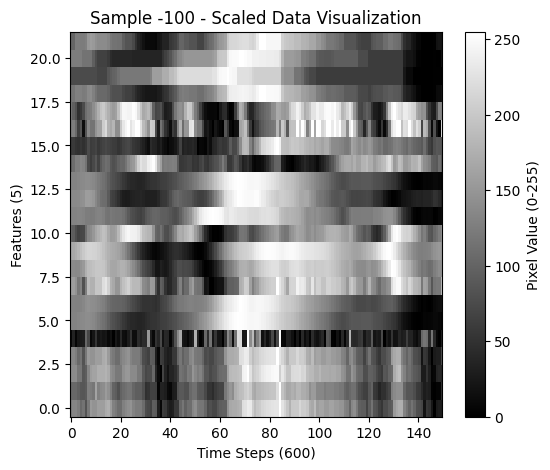

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def create_image_from_data(X_scaled: np.ndarray, sample_idx: int = 0) -> None:
    """
    Creates an image (600x5 pixels) from the scaled data (values between 0 and 1).
    The values are mapped from the range [0, 1] to [0, 255] for visual representation.

    Args:
        X_scaled: Scaled data array of shape (num_samples, 600, 5).
        sample_idx: Index of the sample to visualize.
    """
    # Get the selected sample (shape: 600, 5)
    sample_data = X_scaled[sample_idx, :, :]

    # Map the data from [0, 1] to [0, 255]
    sample_data_mapped = (sample_data * 255).astype(np.uint8)

    # Create the image (600x5)
    plt.figure(figsize=(6, 5))
    plt.imshow(sample_data_mapped.T, cmap='gray', aspect='auto', origin='lower', interpolation='none')

    # Set axis labels and title
    plt.title(f"Sample {sample_idx} - Scaled Data Visualization")
    plt.xlabel('Time Steps (600)')
    plt.ylabel('Features (5)')
    plt.colorbar(label='Pixel Value (0-255)')

    # Show the image
    plt.show()

# Example usage to visualize the first sample
create_image_from_data(X_test_scaled, sample_idx=-100)

# Prepare model

In [31]:

class Simple1DCNN(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.3):
        """
        An improved 1D CNN for time-series classification.

        Args:
            num_channels (int): Number of input channels (features). Defaults to 5 (e.g., open/high/low/close/volume).
            seq_len (int): Number of timesteps in each sample (e.g., 600).
            num_classes (int): Number of output classes (e.g., 3 for 'short','flat','long').
            dropout_p (float): Dropout probability for regularization. Defaults to 0.3.
        """
        super(Simple1DCNN, self).__init__()
        
        # -------------------------
        # Convolution Block 1
        # -------------------------
        self.conv1 = nn.Conv1d(
            in_channels=num_channels, 
            out_channels=32,
            kernel_size=5,         # Larger kernel for broader context
            stride=1, 
            padding=2              # "same" padding
        )
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # Halves sequence length: 600 -> 300

        # -------------------------
        # Convolution Block 2
        # -------------------------
        self.conv2 = nn.Conv1d(
            in_channels=32, 
            out_channels=64,
            kernel_size=5, 
            stride=1, 
            padding=2
        )
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # 300 -> 150

        # -------------------------
        # Convolution Block 3
        # -------------------------
        self.conv3 = nn.Conv1d(
            in_channels=64, 
            out_channels=128,
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)  # 150 -> 75

        # After 3 poolings, seq_len -> seq_len / 8
        # so final sequence length = 600 / 2 / 2 / 2 = 75
        # out channels = 128
        # flattened size = 128 * 75 = 9600
        self.dropout = nn.Dropout(p=dropout_p)

        # self.fc = nn.Linear(128 * (seq_len // 8), num_classes)

        # OPTIONAL: If you want to do global average pooling (instead of flattening),
        # you can comment out the above fc dimension logic and do:
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, channels=num_channels, seq_len)
        """
        # -------------------------
        # Block 1
        # -------------------------
        x = self.conv1(x)    # (batch, 32, seq_len=600)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)    # (batch, 32, 300)

        # -------------------------
        # Block 2
        # -------------------------
        x = self.conv2(x)    # (batch, 64, 300)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)    # (batch, 64, 150)

        # -------------------------
        # Block 3
        # -------------------------
        x = self.conv3(x)    # (batch, 128, 150)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)    # (batch, 128, 75)

        # -------------------------
        # Flatten or Global Pool
        # -------------------------
        # # 1) Flatten approach
        # x = x.view(x.size(0), -1)  # => (batch, 128 * 75)
        
        # # 2) Dropout for regularization
        # x = self.dropout(x)

        # # 3) Fully connected output
        # x = self.fc(x)  # => (batch, num_classes=3)

        # OPTIONAL (Global Pooling) approach:
        x = self.global_pool(x)  # => (batch, 128, 1)
        x = x.squeeze(-1)        # => (batch, 128)
        x = self.dropout(x)
        x = self.fc(x)

        return x

model = Simple1DCNN(num_channels=5, seq_len=600, num_classes=3)


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class Enlarged1DCNN(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4):
        """
        An enlarged 1D CNN for time-series classification with enhanced capacity and regularization.
    
        Args:
            num_channels (int): Number of input channels (features). Defaults to 5 (e.g., open/high/low/close/volume).
            seq_len (int): Number of timesteps in each sample (e.g., 600).
            num_classes (int): Number of output classes (e.g., 3 for 'short','flat','long').
            dropout_p (float): Dropout probability for regularization. Defaults to 0.4.
        """
        super(Enlarged1DCNN, self).__init__()
        
        # -------------------------
        # Convolution Block 1
        # -------------------------
        self.conv1 = nn.Conv1d(
            in_channels=num_channels, 
            out_channels=64,           # Increased from 32 to 64
            kernel_size=7,             
            stride=1, 
            padding=3                  
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # 600 -> 300
        self.dropout1 = nn.Dropout(p=dropout_p)
        
        # -------------------------
        # Convolution Block 2
        # -------------------------
        self.conv2 = nn.Conv1d(
            in_channels=64, 
            out_channels=128,          # Increased from 64 to 128
            kernel_size=5, 
            stride=1, 
            padding=2
        )
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # 300 -> 150
        self.dropout2 = nn.Dropout(p=dropout_p)
        
        # -------------------------
        # Convolution Block 3
        # -------------------------
        self.conv3 = nn.Conv1d(
            in_channels=128, 
            out_channels=256,          # Increased from 128 to 256
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)  # 150 -> 75
        self.dropout3 = nn.Dropout(p=dropout_p)
        
        # -------------------------
        # Convolution Block 4 (Optional)
        # -------------------------
        self.conv4 = nn.Conv1d(
            in_channels=256, 
            out_channels=512,          # Additional layer
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(kernel_size=2)  # 75 -> 37 (rounded down)
        self.dropout4 = nn.Dropout(p=dropout_p)
        
        # -------------------------
        # Fully Connected Layers
        # -------------------------
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(512, 256)              # Increased size
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout_fc2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, seq_len)
        
        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes)
        """
        # -------------------------
        # Block 1
        # -------------------------
        x = self.conv1(x)       # (batch, 64, 600)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)       # (batch, 64, 300)
        x = self.dropout1(x)
    
        # -------------------------
        # Block 2
        # -------------------------
        x = self.conv2(x)       # (batch, 128, 300)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)       # (batch, 128, 150)
        x = self.dropout2(x)
    
        # -------------------------
        # Block 3
        # -------------------------
        x = self.conv3(x)       # (batch, 256, 150)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)       # (batch, 256, 75)
        x = self.dropout3(x)
    
        # -------------------------
        # Block 4 (Optional)
        # -------------------------
        x = self.conv4(x)       # (batch, 512, 75)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)       # (batch, 512, 37)
        x = self.dropout4(x)
    
        # -------------------------
        # Global Pooling and Fully Connected Layers
        # -------------------------
        x = self.global_pool(x) # (batch, 512, 1)
        x = x.squeeze(-1)       # (batch, 512)
        
        x = self.fc1(x)         # (batch, 256)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout_fc1(x)
        
        x = self.fc2(x)         # (batch, 128)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)         # (batch, num_classes)
    
        return x
    
model = Enlarged1DCNN(num_channels=5, seq_len=600, num_classes=3, dropout_p=0.6)



In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_p=0.4):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # If input and output channels differ, adjust the residual connection
        if in_channels != out_channels:
            self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual = nn.Identity()
        
    def forward(self, x):
        residual = self.residual(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResidualEnlarged1DCNN(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4):
        super(ResidualEnlarged1DCNN, self).__init__()
        
        # Initial convolution
        self.conv_initial = nn.Conv1d(num_channels, 64, kernel_size=7, stride=1, padding=3)
        self.bn_initial = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # 600 -> 300
        self.dropout_initial = nn.Dropout(p=dropout_p)
        
        # Residual Blocks
        self.res_block1 = ResidualBlock(64, 128, kernel_size=5, padding=2, dropout_p=dropout_p)
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # 300 -> 150
        self.dropout2 = nn.Dropout(p=dropout_p)
        
        self.res_block2 = ResidualBlock(128, 256, kernel_size=3, padding=1, dropout_p=dropout_p)
        self.pool3 = nn.MaxPool1d(kernel_size=2)  # 150 -> 75
        self.dropout3 = nn.Dropout(p=dropout_p)
        
        self.res_block3 = ResidualBlock(256, 512, kernel_size=3, padding=1, dropout_p=dropout_p)
        self.pool4 = nn.MaxPool1d(kernel_size=2)  # 75 -> 37
        self.dropout4 = nn.Dropout(p=dropout_p)
        
        # Fully Connected Layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (batch, 512, 1)
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout_fc2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Initial convolution
        x = self.conv_initial(x)
        x = self.bn_initial(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.dropout_initial(x)
        
        # Residual Block 1
        x = self.res_block1(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Residual Block 2
        x = self.res_block2(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Residual Block 3
        x = self.res_block3(x)
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Fully connected layers
        x = self.global_pool(x)  # (batch, 512, 1)
        x = x.squeeze(-1)        # (batch, 512)
        
        x = self.fc1(x)          # (batch, 256)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout_fc1(x)
        
        x = self.fc2(x)          # (batch, 128)
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)          # (batch, num_classes)
        
        return x

# Initialize the residual enlarged model
model = ResidualEnlarged1DCNN(num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4)

# The rest of the training setup remains the same as before


In [60]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        kernel_size=3, 
        stride=1, 
        padding=1, 
        dropout_p=0.4
    ):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # If input and output channels differ or stride !=1, adjust the residual connection
        if in_channels != out_channels or stride != 1:
            self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.residual = nn.Identity()
        
    def forward(self, x):
        residual = self.residual(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResidualEnlarged1DCNN2(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4):
        super(ResidualEnlarged1DCNN2, self).__init__()
        
        # Initial convolution with stride=2 for initial downsampling
        self.conv_initial = nn.Conv1d(num_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn_initial = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # Further downsampling
        self.dropout_initial = nn.Dropout(p=dropout_p)
        
        # Residual Blocks
        self.res_block1 = ResidualBlock(64, 128, kernel_size=5, stride=2, padding=2, dropout_p=dropout_p)
        self.dropout2 = nn.Dropout(p=dropout_p)
        
        self.res_block2 = ResidualBlock(128, 256, kernel_size=3, stride=2, padding=1, dropout_p=dropout_p)
        self.dropout3 = nn.Dropout(p=dropout_p)
        
        self.res_block3 = ResidualBlock(256, 512, kernel_size=3, stride=2, padding=1, dropout_p=dropout_p)
        self.dropout4 = nn.Dropout(p=dropout_p)
        
        # Fully Connected Layers with Global Avg and Max Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # (batch, 512, 1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)  # (batch, 512, 1)
        self.fc1 = nn.Linear(512 * 2, 256)  # Concatenated features
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout_fc2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Initial convolution
        x = self.conv_initial(x)          # Output shape: (batch, 64, seq_len/2)
        x = self.bn_initial(x)
        x = self.relu(x)
        x = self.pool1(x)                 # Output shape: (batch, 64, seq_len/4)
        x = self.dropout_initial(x)
        
        # Residual Block 1
        x = self.res_block1(x)            # Output shape: (batch, 128, seq_len/8)
        x = self.dropout2(x)
        
        # Residual Block 2
        x = self.res_block2(x)            # Output shape: (batch, 256, seq_len/16)
        x = self.dropout3(x)
        
        # Residual Block 3
        x = self.res_block3(x)            # Output shape: (batch, 512, seq_len/32)
        x = self.dropout4(x)
        
        # Global Pooling
        avg_pooled = self.global_avg_pool(x)  # Shape: (batch, 512, 1)
        max_pooled = self.global_max_pool(x)  # Shape: (batch, 512, 1)
        x = torch.cat((avg_pooled, max_pooled), dim=1)  # Shape: (batch, 1024, 1)
        x = x.squeeze(-1)                        # Shape: (batch, 1024)
        
        # Fully Connected Layers
        x = self.fc1(x)                          # Shape: (batch, 256)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout_fc1(x)
        
        x = self.fc2(x)                          # Shape: (batch, 128)
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)                          # Shape: (batch, num_classes)
        
        return x
model = ResidualEnlarged1DCNN2(num_channels=5, seq_len=600, num_classes=3, dropout_p=0.6)


In [79]:
import torch
import torch.nn as nn

class FeatureSpecific1DCNN_MaxPooling(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4):
        """
        Initializes the FeatureSpecific1DCNN model with 3 CNN layers per feature,
        per-branch max pooling, and a final MLP.

        Args:
            num_channels (int): Number of distinct features (default: 5).
            seq_len (int): Length of each time series sequence (default: 600).
            num_classes (int): Number of output classes (default: 3).
            dropout_p (float): Dropout probability (default: 0.4).
        """
        super(FeatureSpecific1DCNN_MaxPooling, self).__init__()
        self.num_channels = num_channels
        self.seq_len = seq_len
        self.num_classes = num_classes
        self.dropout_p = dropout_p

        # Define the CNN blocks to reduce sequence length from 600 to 9 in 3 layers
        self.cnn_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=3),  # 600 -> 198
                nn.ReLU(),
                nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7, stride=3), # 198 -> 64
                nn.ReLU(),
                nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7, stride=7), # 64 -> 9
                nn.ReLU(),
                nn.AdaptiveMaxPool1d(output_size=1)  # Global max pooling over the sequence length
            ) for _ in range(num_channels)
        ])

        # Each branch will now output (batch_size, 32, 1) after pooling
        # Flattened size per branch: 32
        self.flattened_size_per_branch = 32

        # Calculate the concatenated size from all branches
        self.concatenated_size = num_channels * self.flattened_size_per_branch  # e.g., 5 * 32 = 160

        # Define the final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(self.concatenated_size, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_channels, seq_len).

        Returns:
            torch.Tensor: Logits for each class.
        """
        # List to hold outputs from each CNN branch
        branch_outputs = []

        # Process each feature through its corresponding CNN branch
        for i in range(self.num_channels):
            # Extract the i-th feature: shape (batch_size, 1, seq_len)
            feature = x[:, i].unsqueeze(1)
            cnn_out = self.cnn_blocks[i](feature)  # Shape: (batch_size, 32, 1)
            cnn_out = cnn_out.view(cnn_out.size(0), -1)  # Flatten: (batch_size, 32)
            branch_outputs.append(cnn_out)

        # Concatenate all branch outputs: shape (batch_size, 160)
        concatenated = torch.cat(branch_outputs, dim=1)  # 5 branches * 32 = 160

        # Pass through the final MLP
        logits = self.final_mlp(concatenated)  # Shape: (batch_size, num_classes)

        return logits

# Instantiate the modified model
model = FeatureSpecific1DCNN_MaxPooling(num_channels=22, seq_len=600, num_classes=3, dropout_p=0.4)

# Print the model architecture to verify changes
print(model)


FeatureSpecific1DCNN_MaxPooling(
  (cnn_blocks): ModuleList(
    (0-21): 22 x Sequential(
      (0): Conv1d(1, 32, kernel_size=(7,), stride=(3,))
      (1): ReLU()
      (2): Conv1d(32, 32, kernel_size=(7,), stride=(3,))
      (3): ReLU()
      (4): Conv1d(32, 32, kernel_size=(7,), stride=(7,))
      (5): ReLU()
      (6): AdaptiveMaxPool1d(output_size=1)
    )
  )
  (final_mlp): Sequential(
    (0): Linear(in_features=704, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [82]:
class TimeSeriesModel(nn.Module): 
    def __init__(self, num_channels=5, seq_len=150, num_classes=3, dropout_p=0.4):
        super(TimeSeriesModel, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv1d(
            in_channels=num_channels,      # 5 features: open, close, high, low, volume
            out_channels=64,               # Number of filters
            kernel_size=3,                 # Size of the convolutional kernel
            padding=1                      # To maintain the sequence length
        )
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.8)

        self.conv2 = nn.Conv1d(
            in_channels=64,      # 5 features: open, close, high, low, volume
            out_channels=16,               # Number of filters
            kernel_size=3,                 # Size of the convolutional kernel
            padding=1                      # To maintain the sequence length
        )
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        
        # Optionally, add more convolutional layers or pooling layers here
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(2400, 16)
        self.dropout3 = nn.Dropout(0.4)

        self.fc = nn.Linear(16, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)           # Apply convolution: (batch_size, 64, seq_len)
        x = self.dropout1(x)         # Apply dropout
        x = self.relu(x)  
        x = self.conv2(x)           # Apply convolution: (batch_size, 64, seq_len)
        x = self.dropout2(x)         # Apply dropout
        x = self.relu(x)          # Apply ReLU activation
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64*seq_len)
        x = self.fc1(x)              # Fully connected layer to (batch_size, num_classes)
        x = self.dropout3(x)         # Apply dropout
        x = self.fc(x)              # Fully connected layer to (batch_size, num_classes)
        return x
    
model = TimeSeriesModel(num_channels=5, seq_len=150, num_classes=3, dropout_p=0.6)

# Print the model architecture to verify changes
print(model)

TimeSeriesModel(
  (conv1): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (dropout1): Dropout(p=0.8, inplace=False)
  (conv2): Conv1d(64, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=2400, out_features=16, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)


In [83]:
import torch
import torch.nn as nn

class HybridCNN(nn.Module):
    def __init__(self, num_features=5, seq_len=600, num_classes=3, dropout_p=0.5):
        super(HybridCNN, self).__init__()
        
        # Shared Convolutional Layer
        self.shared_conv1 = nn.Conv1d(
            in_channels=num_features,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.shared_relu = nn.ReLU()
        self.shared_dropout = nn.Dropout1d(p=0.4)  # Increased dropout
        
        # Feature-Specific Convolutional Layers
        self.feature_cnns = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Dropout1d(p=0.6),  # Increased dropout
                nn.Conv1d(128, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Dropout1d(p=0.4)   # Increased dropout
            )
            for _ in range(num_features)
        ])
        
        # Fully Connected Layers with Increased Dropout
        self.fc1 = nn.Linear(32 * seq_len + 32 * seq_len * num_features, 256)
        self.fc_dropout = nn.Dropout(p=0.8)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        """
        Input shape: (batch_size, num_features=5, seq_len=600)
        """
        # Shared Convolution
        shared_out = self.shared_conv1(x)  # Shape: (batch_size, 64, seq_len)
        shared_out = self.shared_relu(shared_out)
        shared_out = self.shared_dropout(shared_out)
        
        # Feature-Specific Convolutions
        feature_outputs = []
        for i, cnn in enumerate(self.feature_cnns):
            feature = x[:, i:i+1, :]  # Shape: (batch_size, 1, seq_len)
            feature_out = cnn(feature)  # Shape: (batch_size, 64, seq_len)
            feature_outputs.append(feature_out)
        
        # Concatenate All Outputs
        all_features = torch.cat([shared_out] + feature_outputs, dim=1)  # Shape: (batch_size, 64 + 64*num_features, seq_len)
        all_features = all_features.view(all_features.size(0), -1)       # Shape: (batch_size, (64 + 64*num_features)*seq_len)
        
        # Fully Connected Layers
        x = self.fc1(all_features)          # Shape: (batch_size, 256)
        x = self.fc_dropout(x)              # Dropout before activation
        x = nn.ReLU()(x)                    # Activation
        x = self.fc2(x)                     # Shape: (batch_size, num_classes)
        return x
    
model = HybridCNN(num_features=22, seq_len=150, num_classes=3, dropout_p=0.8)

# Print the model architecture to verify changes
print(model)

HybridCNN(
  (shared_conv1): Conv1d(22, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (shared_relu): ReLU()
  (shared_dropout): Dropout1d(p=0.4, inplace=False)
  (feature_cnns): ModuleList(
    (0-21): 22 x Sequential(
      (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Dropout1d(p=0.6, inplace=False)
      (3): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): ReLU()
      (5): Dropout1d(p=0.4, inplace=False)
    )
  )
  (fc1): Linear(in_features=110400, out_features=256, bias=True)
  (fc_dropout): Dropout(p=0.8, inplace=False)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


# Load model

In [68]:
# # Reconstruct the model architecture
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = Simple1DCNN(num_channels=5, seq_len=600, num_classes=3)

# # Load the saved state dictionary
# model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# # Move to device
# model.to(device)


# Train model

In [76]:
criterion = nn.CrossEntropyLoss()

In [80]:
import numpy as np

# Suppose X_train_scaled.shape = (19000, 600, 5)
# and y_train_encoded.shape = (19000,)
X_train_transposed = np.transpose(X_train_scaled, (0, 2, 1))  # (19000, 5, 600)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.from_numpy(X).float()  # shape: (num_samples, channels, seq_len)
        self.y = torch.from_numpy(y).long()   # shape: (num_samples,)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return (features, label) for sample 'idx'
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_transposed, y_train_encoded)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Suppose X_val_scaled.shape = (val_size, 600, 5)
# Suppose y_val_encoded.shape = (val_size,)

# 1) Transpose
X_val_transposed = np.transpose(np.concatenate((X_val_scaled, X_test_scaled), axis=0), (0, 2, 1))  # shape: (val_size, 5, 600)

# 2) Wrap in a Dataset
val_dataset = TimeSeriesDataset(X_val_transposed, np.concatenate((y_val_encoded, y_test_encoded), axis=0))

# 3) Create DataLoader (batch_size can match or differ from train)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assume train_loader and val_loader are predefined DataLoader instances
# Also assume that the model is defined and instantiated as `model`

# Initialize the device, model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
l2_lambda = 1e-4  # You can adjust this value based on your needs

# Initialize the optimizer with weight_decay for L2 regularization
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=l2_lambda)

# Initialize the learning rate scheduler
# Here, ReduceLROnPlateau reduces the LR by a factor of 0.1 if validation loss doesn't improve for 5 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)

# Set the desired validation loss threshold
validation_threshold = 0.25

epoch_loss = 1
epoch = 0

while True:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, pred = torch.max(outputs, 1)
        correct += (pred == y_batch).sum().item()
        total += y_batch.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    epoch += 1
    
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    
    # Validation every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        # To collect predictions and true labels for further metrics
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)              # shape: (batch_size, num_classes)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)

                # Predictions
                _, predicted = torch.max(outputs, 1)  # shape: (batch_size,)
                
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
                
                # Store predictions & labels for confusion matrix, etc.
                all_preds.append(predicted.cpu().numpy())
                all_labels.append(y_batch.cpu().numpy())

        # Convert lists of arrays into a single 1D array
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        val_loss /= total
        val_acc = correct / total

        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        # --------------------------------------------------------------------------
        # Additional Metrics
        # --------------------------------------------------------------------------

        # 1) Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print("Confusion Matrix:")
        print(cm)

        # 2) Classification Report
        #    If you have 3 classes: 0="short", 1="flat", 2="long" (example)
        target_names = ["short", "flat", "long"]  # adjust if needed
        report = classification_report(all_labels, all_preds, target_names=target_names)
        print("Classification Report:")
        print(report)
        
        # Step the scheduler with the validation loss
        scheduler.step(val_loss)
        print(f"Learning Rate after scheduler step: {optimizer.param_groups[0]['lr']:.6f}")
        
        # If the validation loss is acceptable, stop training
        if val_loss <= validation_threshold or optimizer.param_groups[0]['lr'] < 1e-8:
            print(f"Validation loss has reached the threshold of {validation_threshold:.4f}, stopping training.")
            break


e:\AICore\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 1.2320, Acc: 0.5198
Epoch 2, Loss: 0.7277, Acc: 0.7008
Epoch 3, Loss: 0.6139, Acc: 0.7569
Epoch 4, Loss: 0.5689, Acc: 0.7760
Epoch 5, Loss: 0.5178, Acc: 0.7934
Validation Loss: 0.4268, Validation Acc: 0.8261
Confusion Matrix:
[[273  39  10]
 [ 39 248  35]
 [ 11  34 277]]
Classification Report:
              precision    recall  f1-score   support

       short       0.85      0.85      0.85       322
        flat       0.77      0.77      0.77       322
        long       0.86      0.86      0.86       322

    accuracy                           0.83       966
   macro avg       0.83      0.83      0.83       966
weighted avg       0.83      0.83      0.83       966

Learning Rate after scheduler step: 0.001000
Epoch 6, Loss: 0.5184, Acc: 0.7981
Epoch 7, Loss: 0.4939, Acc: 0.8101
Epoch 8, Loss: 0.4819, Acc: 0.8130
Epoch 9, Loss: 0.4683, Acc: 0.8166
Epoch 10, Loss: 0.4488, Acc: 0.8208
Validation Loss: 0.4173, Validation Acc: 0.8323
Confusion Matrix:
[[292  19  11]
 [ 51 2

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), MODEL_PATH)
print(f"Final model saved to {MODEL_PATH}")

# Validate model

In [ ]:
target_names = ["short", "flat", "long"]  # Adjust based on your class names
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


Validation Loss: 0.5500, Validation Acc: 0.8406


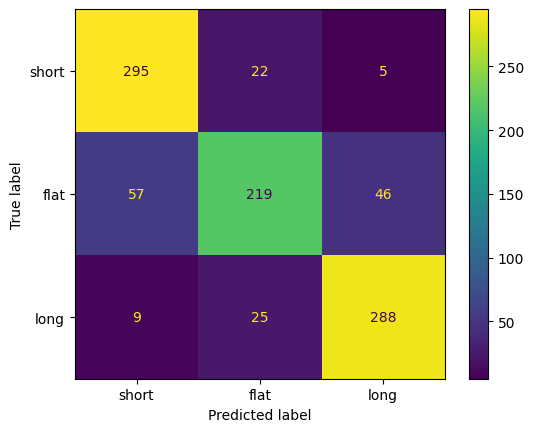

Classification Report:
              precision    recall  f1-score   support

       short       0.84      0.91      0.88       322
        flat       0.85      0.69      0.76       322
        long       0.83      0.92      0.87       322

    accuracy                           0.84       966
   macro avg       0.84      0.84      0.84       966
weighted avg       0.84      0.84      0.84       966



In [85]:
import torch
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

model.eval()
val_loss = 0.0
correct = 0
total = 0

# To collect predictions and true labels for further metrics
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)              # shape: (batch_size, num_classes)
        loss = criterion(outputs, y_batch)

        val_loss += loss.item() * X_batch.size(0)

        # Predictions
        _, predicted = torch.max(outputs, 1)  # shape: (batch_size,)
        
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        
        # Store predictions & labels for confusion matrix, etc.
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

# Convert lists of arrays into a single 1D array
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

val_loss /= total
val_acc = correct / total

print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

# --------------------------------------------------------------------------
# Additional Metrics
# --------------------------------------------------------------------------

target_names = ["short", "flat", "long"]  # adjust if needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names) 
disp.plot() 
# And show it: 
plt.show()
# 2) Classification Report
#    If you have 3 classes: 0="short", 1="flat", 2="long" (example)
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


# Test model

In [86]:
# Suppose X_test_scaled.shape = (test_size, 600, 5)
# Suppose y_test_encoded.shape = (test_size,)

# 1) Transpose
X_test_transposed = np.transpose(X_test_scaled, (0, 2, 1))  # shape: (test_size, 5, 600)

# 2) Wrap in a Dataset
test_dataset = TimeSeriesDataset(X_test_transposed, y_test_encoded)

# 3) Create DataLoader (batch_size can match or differ from train)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [87]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
val_loss = 0.0
correct = 0
total = 0

# To collect predictions and true labels for further metrics
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)              # shape: (batch_size, num_classes)
        loss = criterion(outputs, y_batch)

        val_loss += loss.item() * X_batch.size(0)

        # Predictions
        _, predicted = torch.max(outputs, 1)  # shape: (batch_size,)
        
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        
        # Store predictions & labels for confusion matrix, etc.
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

# Convert lists of arrays into a single 1D array
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

val_loss /= total
val_acc = correct / total

print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

# --------------------------------------------------------------------------
# Additional Metrics
# --------------------------------------------------------------------------

# 1) Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 2) Classification Report
#    If you have 3 classes: 0="short", 1="flat", 2="long" (example)
target_names = ["short", "flat", "long"]  # adjust if needed
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


Validation Loss: 0.5729, Validation Acc: 0.8323
Confusion Matrix:
[[148  12   3]
 [ 24 111  28]
 [  5  10 148]]
Classification Report:
              precision    recall  f1-score   support

       short       0.84      0.91      0.87       163
        flat       0.83      0.68      0.75       163
        long       0.83      0.91      0.87       163

    accuracy                           0.83       489
   macro avg       0.83      0.83      0.83       489
weighted avg       0.83      0.83      0.83       489



In [102]:
# Let's do inference on a single sample from X_test
predicted_labels = []
model.eval()

for X_single in X_test_slice:
    X_single_scaled = MinMaxScaler().fit_transform(X_single)  # shape (600,5)
    X_single_scaled = np.expand_dims(X_single_scaled, axis=0)  # => (1,600,5)
    X_single_transposed = np.transpose(X_single_scaled, (0, 2, 1))  # => (1,5,600)
    X_single_tensor = torch.from_numpy(X_single_transposed).float().to(device)
    with torch.no_grad():
        output = model(X_single_tensor)   # => shape (1,3)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()  # 0,1,2

    label_map = {0:"short",1:"flat",2:"long"}
    predicted_labels.append(label_map[predicted_label])

In [104]:
kek = labels_test_slice == predicted_labels
unique, counts = np.unique(kek, return_counts=True)

dict(zip(unique, counts))

{False: 466, True: 1283}

In [154]:
288585/60/ 24

200.40625

In [157]:
compute_trading_statistics(X_test_slice, y_test_slice, labels_test_slice,  500, 100)
# compute_profit(X, y, predicted_labels)


TradingStatisticDTO(initial_capital=500, final_capital=590.4787661114784, total_profit=90.47876611147844, average_profit=0.05173171304258344, return_on_investment=18.095753222295688, num_trades=1749, long_trades=164, short_trades=166, flat_trades=1419, position_size_per_trade=100)

In [158]:
compute_trading_statistics(X_test_slice, y_test_slice, predicted_labels, 500, 100)
# compute_profit(X, y, labels)


TradingStatisticDTO(initial_capital=500, final_capital=608.546619174336, total_profit=108.54661917433604, average_profit=0.062062103587384815, return_on_investment=21.70932383486721, num_trades=1749, long_trades=385, short_trades=356, flat_trades=1008, position_size_per_trade=100)

In [127]:
def plot_input_output_combined_with_label(
    input_sequence: np.ndarray,
    output_sequence: np.ndarray,
    label: str,
    title: str = "Input + Output Window on One Chart"
):
    """
    Plots both input and output windows on a single candlestick chart.
    The output window candles will be overlaid in a color depending on 'label':
      - long -> green
      - short -> red
      - flat -> blue

    Args:
        input_sequence (np.ndarray): OHLCV data for the input window (shape: [N, >=5])
        output_sequence (np.ndarray): OHLCV data for the output window (shape: [M, >=5])
        label (str): The trading signal for the output window ('long', 'short', 'flat').
        title (str): The title of the chart.
    """

    # Use only the first 5 columns (OHLCV)
    input_sequence = input_sequence[:, :5]
    output_sequence = output_sequence[:, :5]

    # Generate a continuous datetime index for plotting
    input_dates = pd.date_range(start="2023-01-01", periods=len(input_sequence), freq="min")
    output_dates = pd.date_range(start=input_dates[-1] + pd.Timedelta(minutes=1), periods=len(output_sequence), freq="min")

    # Convert to DataFrames with appropriate columns
    input_df = pd.DataFrame(input_sequence, columns=["Open", "High", "Low", "Close", "Volume"], index=input_dates)
    output_df = pd.DataFrame(output_sequence, columns=["Open", "High", "Low", "Close", "Volume"], index=output_dates)

    # Concatenate input and output DataFrames
    combined_df = pd.concat([input_df, output_df])

    # Create a market colors style for the input sequence (standard green/red)
    input_market_colors = mpf.make_marketcolors(
        up='green', down='red', edge='inherit', wick='inherit', volume='inherit'
    )
    input_style = mpf.make_mpf_style(marketcolors=input_market_colors)

    # Plot the combined data with the input sequence style
    fig, axes = mpf.plot(
        combined_df,
        type='candle',
        style=input_style,
        volume=True,
        mav=(20, 50),
        returnfig=True,
        title=title,
        figsize=(12, 8),
        show_nontrading=True
    )
    ax_main = axes[0]  # main price axis

    # Determine the output candlestick color based on label
    if label == 'long':
        color_up = 'green'
        color_down = 'green'
    elif label == 'short':
        color_up = 'red'
        color_down = 'red'
    else:  # 'flat'
        color_up = 'blue'
        color_down = 'blue'

    # Create a market colors style for the output sequence
    output_market_colors = mpf.make_marketcolors(
        up=color_up,
        down=color_down,
        edge='inherit',
        wick='inherit',
        volume='inherit'
    )
    output_style = mpf.make_mpf_style(marketcolors=output_market_colors)

    # Overlay the output sequence with its own style
    mpf.plot(
        output_df,
        type='candle',
        ax=ax_main,
        style=output_style,
        volume=False,
        mav=(20, 50),
        show_nontrading=True
    )


In [148]:
for idx in random.sample(range(len(X_test_slice)), 100):
    sample_idx = X_test_slice[idx]
    print("expected/predicted: ", labels_test_slice[idx], predicted_labels[idx], "correct: ", "model" if \
        compute_profit(np.expand_dims(X_test_slice[idx], axis=0), np.expand_dims(y_test_slice[idx], axis=0), np.expand_dims(predicted_labels[idx], axis=0))\
        >= \
        compute_profit(np.expand_dims(X_test_slice[idx], axis=0), np.expand_dims(y_test_slice[idx], axis=0), np.expand_dims(labels_test_slice[idx], axis=0))\
        else "algo"
            )
    # plot_input_output_combined_with_label(
    #     X_test_slice[idx],
    #     y_test_slice[idx],
    #     label=predicted_labels[idx],
    #     title="Input+Output, Colored by Label"
    # )


expected/predicted:  flat flat correct:  model
expected/predicted:  flat flat correct:  model
expected/predicted:  flat short correct:  model
expected/predicted:  flat long correct:  algo
expected/predicted:  flat flat correct:  model
expected/predicted:  flat long correct:  algo
expected/predicted:  flat flat correct:  model
expected/predicted:  short short correct:  model
expected/predicted:  flat flat correct:  model
expected/predicted:  flat long correct:  algo
expected/predicted:  flat flat correct:  model
expected/predicted:  flat flat correct:  model
expected/predicted:  short short correct:  model
expected/predicted:  flat short correct:  model
expected/predicted:  flat flat correct:  model
expected/predicted:  flat flat correct:  model
expected/predicted:  long short correct:  algo
expected/predicted:  flat flat correct:  model
expected/predicted:  long long correct:  model
expected/predicted:  flat flat correct:  model
expected/predicted:  flat flat correct:  model
expected/p